# Introduction to Data Cleaning for Office Occupancy Prediction

In this Jupyter notebook, we embark on the essential process of data cleaning and preprocessing with the goal of preparing datasets for accurate office occupancy prediction. Our focus is on three key datasets: meeting room bookings, event activities, and staff attendance, collected over the span of a year. The objective of this phase is to refine and enhance the quality of our data by addressing anomalies, ensuring data consistency, and implementing necessary transformations. This meticulous preparation is crucial for the subsequent analysis and modeling stages, particularly for employing predictive modeling techniques such as Facebook's Prophet. Through this notebook, we will navigate the steps of importing and preprocessing data, merging datasets for a unified analysis framework, transforming and engineering features for improved model performance, and conducting thorough data visualization and outlier detection. Our ultimate aim is to ensure the data is primed for generating accurate and actionable occupancy forecasts, thereby facilitating more informed decision-making in office space management and optimization.

## Setting Up the Environment for Data Cleaning

Before diving into the data cleaning process, it's crucial to set up our working environment by importing the necessary libraries and tools. This setup is foundational for handling, analyzing, and visualizing the data effectively throughout the notebook. Here's a brief overview of the libraries we're using and their roles in our data cleaning journey:

- **Pandas**: The cornerstone of our data manipulation and analysis, allowing us to read, preprocess, and aggregate our datasets.
- **NumPy**: Provides support for numerical operations, including mathematical transformations needed during data preprocessing.
- **Scikit-learn's OneHotEncoder**: Useful for encoding categorical variables as part of feature engineering, enhancing model interpretability.
- **Matplotlib & Seaborn**: Our go-to libraries for data visualization, enabling us to plot distributions, trends, and correlations within the data, making insights more accessible.
- **SciPy's Stats Module**: Offers statistical functions, crucial for identifying and handling outliers within our datasets.
- **Pandas' Holiday and CustomBusinessDay**: These classes help us manage and account for holidays and custom business days, ensuring our data reflects actual office occupancy patterns.

This comprehensive suite of tools equips us to tackle the various aspects of data cleaning and preparation, setting the stage for a detailed analysis and modeling process.


In [21]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.tseries.holiday import Holiday, AbstractHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from scipy import stats
import matplotlib.pyplot as plt


### Loading the Datasets

With our environment set up, the next step in our data cleaning journey is to load the datasets into our notebook. These datasets form the core of our analysis and modeling work, each capturing different facets of office occupancy:

- **Meeting Room Bookings**: This dataset includes details on the bookings of meeting rooms within the office over the year, such as the date and time of bookings, duration, and room capacity.
- **Event Activities**: Records various events occurring throughout the year, detailing the type of event, its expected attendance, and timing.
- **Staff Attendance**: Tracks the daily attendance of staff, providing insights into the overall occupancy trends within the office.

In [22]:
# Read datasets
meeting_room_bookings_year = pd.read_csv('./data/meeting_room_bookings_year.csv')
event_activities_year = pd.read_csv('./data/event_activities_year.csv')
staff_attendance_year = pd.read_csv('./data/staff_attendance_year.csv')


### Preprocessing Staff Attendance Data

The initial phase of data cleaning involves preprocessing the staff attendance dataset. This step is vital for transforming the data into a more analyzable format, which will significantly aid in our subsequent analysis and predictive modeling efforts. Here's what we accomplish in this preprocessing step:

- **Combining Date and Time into a Single Datetime Column**

To capture the precise moments of staff attendance, we combine the `Date` and `Report time` columns into a single `DateTime` column. This consolidation is crucial for time series analysis, allowing us to observe attendance patterns down to the hour.

- **Aggregating Attendance Data**

With the DateTime column established, we proceed to aggregate the data to sum up the total number of bodies present at each recorded datetime. This aggregation provides us with a clearer view of occupancy levels throughout the year.

In [23]:



# Preprocess Staff Attendance Data
staff_attendance_year['DateTime'] = pd.to_datetime(staff_attendance_year['Date'].astype(str) + ' ' + staff_attendance_year['Report time'].astype(str))
staff_agg = staff_attendance_year.groupby('DateTime').agg({'Bodies Present': 'sum'}).reset_index() 
staff_agg.head()


,DateTime,Bodies Present
0,2023-01-02 08:00:00,39
1,2023-01-02 09:00:00,31
2,2023-01-02 10:00:00,34
3,2023-01-02 11:00:00,29
4,2023-01-02 12:00:00,20


### Processing Meeting Room Bookings Data

After addressing the staff attendance dataset, our next focus shifts to refining the meeting room bookings data. This dataset encapsulates information on the usage of meeting spaces within the office, a key component in understanding overall occupancy dynamics. The processing steps applied here aim to render the data more suitable for time series analysis and predictive modeling.

- **Creating a Unified DateTime Column**

Similar to the staff attendance data, we consolidate the `Date` and `Start Time` into a single `DateTime` column for the meeting room bookings. This step ensures that each booking's timing is precisely captured, facilitating a detailed analysis of meeting room occupancy over time.

- **Summarizing Room Capacity**
To get a comprehensive view of the capacity utilized during meetings, we aggregate the data by the newly created DateTime column, summing up the Room Capacity for each datetime. This aggregation highlights the total meeting room capacity engaged at any given moment, offering insights into the demand for meeting spaces.

In [24]:


# Process Meeting Room Bookings Data
meeting_room_bookings_year['DateTime'] = pd.to_datetime(meeting_room_bookings_year['Date'].astype(str) + ' ' + meeting_room_bookings_year['Start Time'].astype(str))
room_capacity_sum = meeting_room_bookings_year.groupby('DateTime')['Room Capacity'].sum().reset_index()


### Processing Evening Activities Data

The processing of the evening activities data follows a similar methodology to the meeting room bookings, focusing on events that contribute to the overall occupancy of the office space. These activities, ranging from team-building exercises to training sessions, significantly influence the dynamic use of office areas. Here's how we process this dataset:

- **Creating a Unified DateTime Column**

For the event activities data, we also combine the `Date` and `Start Time` into a `DateTime` column. This amalgamation is essential for aligning event data with the temporal framework used for staff attendance and meeting room bookings, ensuring consistency across all datasets.
- **Summarizing Expected Attendance**

Understanding the impact of events on office occupancy requires a grasp of how many individuals are expected at these activities. Therefore, we aggregate the event data by `DateTime`, summing up the `Expected Attendance` for each event. This gives us a clear picture of the anticipated occupancy due to events at any given time.

In [25]:

# Process Evening Activities Data
event_activities_year['DateTime'] = pd.to_datetime(event_activities_year['Date'].astype(str) + ' ' + event_activities_year['Start Time'].astype(str))
expected_attendance_sum = event_activities_year.groupby('DateTime')['Expected Attendance'].sum().reset_index()



# Preparing Data for Occupancy Prediction with Prophet

After processing our datasets, the next crucial step is to prepare the data for occupancy prediction using Facebook's Prophet. This involves merging the staff attendance, meeting room bookings, and event activities data into a single dataframe, transforming the data where necessary, and selecting relevant features for the prediction model. Here's how we accomplish this:

## Merging Datasets

The datasets are merged based on the `DateTime` column, now standardized as `ds` across all datasets, to create a comprehensive view of occupancy-related activities. This unified dataframe, `df_prophet`, serves as the foundation for our predictive modeling.

In [26]:

# Merge Data for Prophet
df_prophet = staff_agg.rename(columns={'DateTime': 'ds', 'Bodies Present': 'y_original'})
room_capacity_sum = room_capacity_sum.rename(columns={'DateTime': 'ds', 'Room Capacity': 'total_room_capacity'})
expected_attendance_sum = expected_attendance_sum.rename(columns={'DateTime': 'ds', 'Expected Attendance': 'total_expected_attendance'})

df_prophet = df_prophet.merge(room_capacity_sum, how='left', on='ds').fillna({'total_room_capacity': 0})
df_prophet = df_prophet.merge(expected_attendance_sum, how='left', on='ds').fillna({'total_expected_attendance': 0})


### Calculating Expected Occupancy
To get a holistic measure of expected office occupancy, we sum the `total_room_capacity` and `total_expected_attendance`, creating an `expected_occupancy` feature. This reflects the combined impact of meetings and events on occupancy.

In [27]:

# Calculate Expected Occupancy for that time
df_prophet['expected_occupancy'] = df_prophet['total_room_capacity'] + df_prophet['total_expected_attendance']


## Transforming the Target Variable
A logarithmic transformation is applied to the target variable (`y_original`) to normalize its distribution, enhancing the model's performance. This transformed variable is denoted as y.

In [28]:

# Apply a logarithmic transformation to the target variable
df_prophet['y'] = np.log1p(df_prophet['y_original'])


## Feature Engineering
To enrich our dataset for the Prophet model, we extract the `month` and `day_of_week` from the `ds` column. These features can serve as additional regressors, potentially improving the model's accuracy by accounting for seasonal and weekly occupancy patterns.



In [29]:

# Add Month and DayOfWeek to later use as regressors for prophet
df_prophet['month'] = pd.to_datetime(df_prophet['ds']).dt.month

df_prophet['day_of_week'] = pd.to_datetime(df_prophet['ds']).dt.dayofweek


#### Creating a Workday Indicator


In [30]:
df_prophet['is_workday'] = df_prophet['day_of_week'].apply(lambda x: 0 if x >= 5 else 1)

**Purpose**: To enhance the forecasting model by introducing a binary indicator (`is_workday`) that differentiates weekdays (workdays) from weekends (non-workdays), based on the assumption that Saturday (5) and Sunday (6) are typically non-working days.

## Final Dataset Selection
We finalize the dataframe by selecting columns relevant to our prediction model: `ds` (datetime), `y` (log-transformed occupancy), `y_original` (actual occupancy), `expected_occupancy`, `month`, and `day_of_week`.

In [31]:

# Select Relevant Columns
df_prophet = df_prophet[['ds', 'y', 'y_original' , 'expected_occupancy', 'month', 'day_of_week', 'is_workday']] 
df_prophet.head(5)

,ds,y,y_original,expected_occupancy,month,day_of_week,is_workday
0,2023-01-02 08:00:00,3.688879,39,0.0,1,0,1
1,2023-01-02 09:00:00,3.465736,31,0.0,1,0,1
2,2023-01-02 10:00:00,3.555348,34,0.0,1,0,1
3,2023-01-02 11:00:00,3.401197,29,0.0,1,0,1
4,2023-01-02 12:00:00,3.044522,20,0.0,1,0,1


## Visualizing the Target Variable Distribution

Understanding the distribution of our target variable is a crucial step in data preprocessing. We focus on visualizing the number of bodies present, which serves as our occupancy measure. 



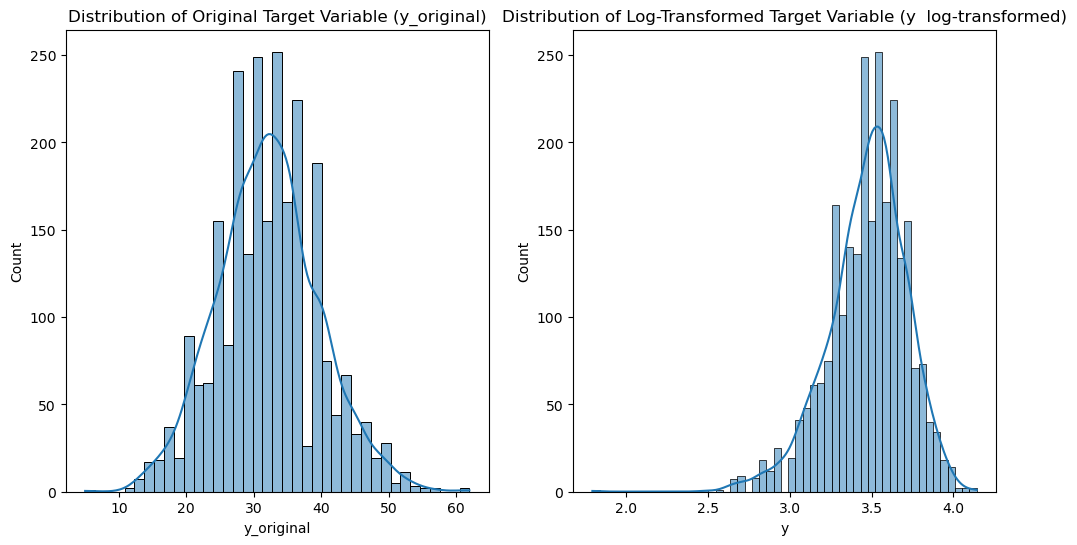

In [32]:


# Distribution of the Target Variable (original and log-transformed)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_prophet['y_original'], kde=True)
plt.title('Distribution of Original Target Variable (y_original)')

plt.subplot(1, 2, 2)
sns.histplot(df_prophet['y'], kde=True)
plt.title('Distribution of Log-Transformed Target Variable (y  log-transformed)')
plt.show()

### Original Target Variable Distribution

The first histogram illustrates the distribution of the occupancy count before any transformations. This visualization helps identify skewness and assess whether the raw data follow a normal distribution, which is a common assumption for many statistical models.

### Log-Transformed Target Variable Distribution

The second histogram displays the data after applying a logarithmic transformation. This transformation often helps normalize the data, reducing skewness and making patterns more evident and consistent, which can be particularly beneficial for linear models and algorithms that assume normality.

The side-by-side comparison of these histograms is instrumental in determining the necessity and effectiveness of the log transformation, guiding the choice of appropriate data preprocessing steps for predictive modeling.

## Analyzing the Target Variable Over Time

Examining the target variable through time enables us to capture trends, patterns, and anomalies in office occupancy. The plot illustrates how the log-transformed count of bodies present fluctuates on a daily basis throughout the year.


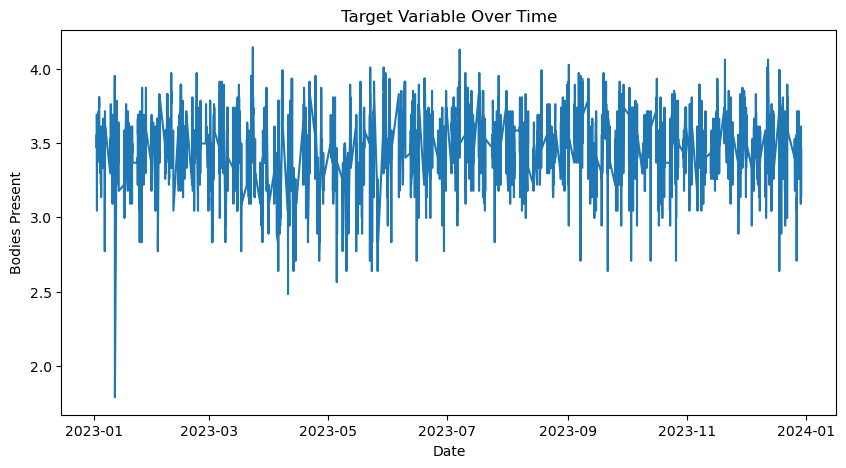

In [33]:
# Target Variable Over Time
plt.figure(figsize=(10, 5))
plt.plot(df_prophet['ds'], df_prophet['y'])
plt.title('Target Variable Over Time')
plt.xlabel('Date')
plt.ylabel('Bodies Present')
plt.show()

### Trends and Seasonality in Office Occupancy

The visualization potentially reveals underlying trends and recurring patterns which could be indicative of seasonality or specific cycles in office attendance. Understanding these patterns is essential for accurate forecasting and can inform decisions on resource management and space planning.

### Occupancy Variability

The degree of variability in the data also becomes evident through this time series plot. Peaks and troughs may correspond to specific events or changes in office policy, suggesting areas for deeper investigation.

Through such visual analysis, we gain valuable insights into the temporal dynamics of office occupancy, which is pivotal in crafting a robust predictive model.


The output confirms whether there are any missing datetimes that would need to be addressed before proceeding with further analysis or modeling. The absence of missing datetimes suggests our dataset is comprehensive and ready for the next stages of our data preparation process.

### Examining Trends of the Target Variable Over Time

The graph provides a comparative view of the office occupancy trends over time, displaying both the original and log-transformed target variable values. This visual comparison is key for several reasons:

#### Understanding Data Fluctuations

The original data's trend line allows us to observe the raw fluctuations in occupancy, offering an unadjusted view of the data's variance and potential outliers.

#### Impact of Log Transformation

Overlaying the log-transformed data, we can see how this transformation affects the scale and visibility of trends within the data. The transformed line typically appears smoother, which may be beneficial for identifying long-term trends and seasonality.

#### Preparing for Predictive Modeling

By comparing these two trend lines, we gain insights into how the data transformation might influence the predictive modeling process. This is especially relevant for models that assume or prefer normally distributed data.



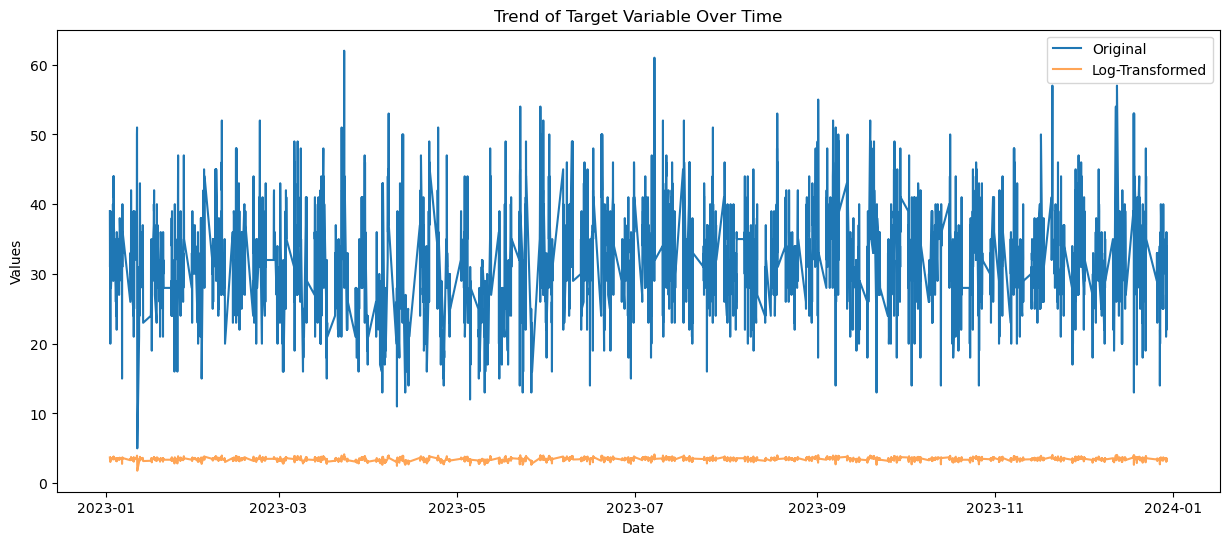

In [34]:
# Trends Over Time
plt.figure(figsize=(15, 6))
plt.plot(df_prophet['ds'], df_prophet['y_original'], label='Original')
plt.plot(df_prophet['ds'], df_prophet['y'], label='Log-Transformed', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Trend of Target Variable Over Time')
plt.legend()
plt.show()

### Analyzing Occupancy by Day of the Week

The bar chart illustrates the average occupancy within the office across different days of the week. Such an analysis is crucial for several reasons:

#### Weekly Occupancy Patterns

It highlights the patterns of attendance and office use throughout a standard workweek, which can inform resource allocation and office space planning.

#### Day-to-Day Variations

Understanding the variations in average occupancy from day to day helps in identifying peak occupancy days, which could influence scheduling decisions for meetings and events.


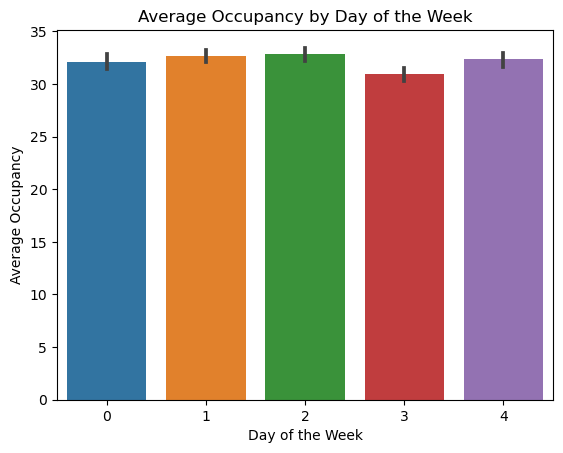

In [35]:


# Average occupancy by day of the week
sns.barplot(x='day_of_week', y='y_original', data=df_prophet)
plt.title('Average Occupancy by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Occupancy')
plt.show()


### Exploring Monthly Trends in Office Occupancy

The bar chart provides a monthly breakdown of average office occupancy, offering valuable insights into how occupancy levels fluctuate throughout the year.

#### Seasonal Impact on Occupancy

The visualization can reveal seasonal trends, such as higher or lower occupancy during certain months, which may correlate with business cycles, holidays, or vacation periods.

#### Planning and Resource Allocation

By understanding which months have higher occupancy, office managers can better plan for resource allocation, space utilization, and even energy management within the office.

#### Informing Forecasting Models

These insights are also beneficial for forecasting models like Prophet, as they underscore the importance of considering monthly effects when predicting future occupancy levels.

Such visual analyses are instrumental in uncovering the underlying seasonal patterns in office occupancy, aiding in strategic planning and predictive modeling efforts.

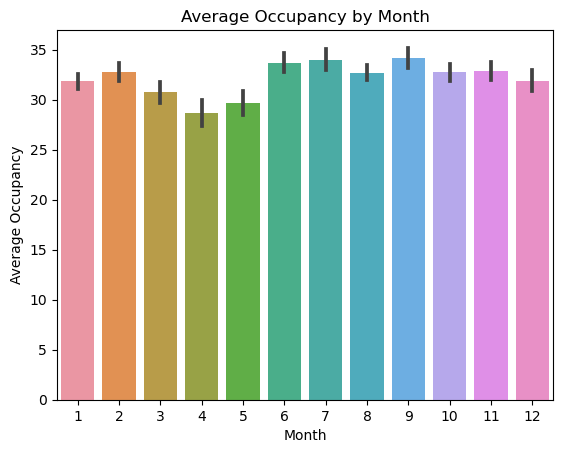

In [36]:

# Average occupancy by month
sns.barplot(x='month', y='y_original', data=df_prophet)
plt.title('Average Occupancy by Month')
plt.xlabel('Month')
plt.ylabel('Average Occupancy')
plt.show()


### Identifying and Visualizing Outliers in Office Occupancy Data

Detecting outliers is a critical step in data cleaning, as these anomalies can significantly affect the performance of predictive models. The graph illustrates our approach to identifying outliers in the office occupancy data using z-scores, a statistical measure that indicates how many standard deviations an element is from the mean.

#### Outlier Detection Using Z-Scores

Outliers are defined as data points that are several standard deviations away from the mean. By calculating z-scores, we can objectively identify these outliers. Typically, a z-score above 3 or below -3 is considered to indicate an outlier.

#### Visualization of Outliers

The plot displays the office occupancy data over time, with outliers marked in red. This visual representation helps us quickly identify any unusual spikes or drops in occupancy that deviate significantly from the general pattern.

#### Implications of Outliers

Removing or appropriately handling these outliers is crucial, as they could represent data entry errors, special one-off events, or other irregularities that do not reflect normal occupancy patterns. By addressing these outliers, we can ensure a more accurate and robust predictive model for future occupancy levels.



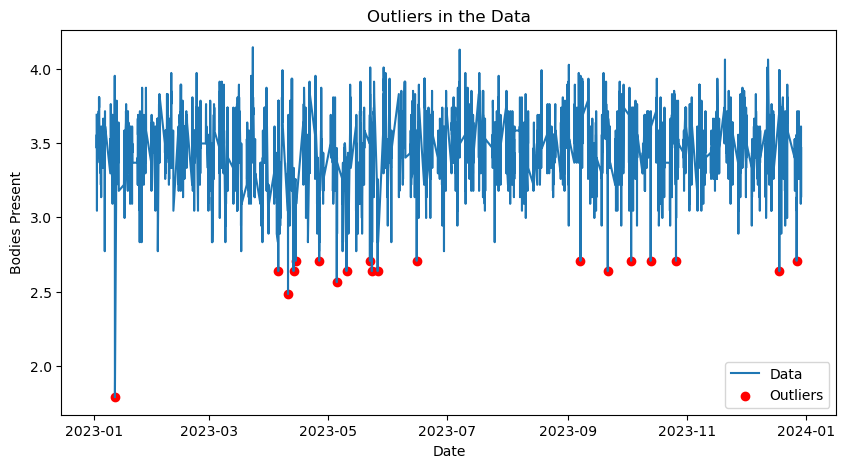

In [37]:

# Calculate z-scores
z_scores = stats.zscore(df_prophet['y'])

# Get absolute values to identify outliers on both tails
abs_z_scores = np.abs(z_scores)

# Identify outliers
outliers = df_prophet[abs_z_scores > 3]


# Plotting to visualize the outliers
plt.figure(figsize=(10, 5))
plt.plot(df_prophet['ds'], df_prophet['y'], label='Data')
plt.scatter(outliers['ds'], outliers['y'], color='red', label='Outliers')
plt.title('Outliers in the Data')
plt.xlabel('Date')
plt.ylabel('Bodies Present')
plt.legend()
plt.show()






### Correlation Analysis for Predictive Modeling

In predictive analytics, understanding the relationships between different variables is crucial. Correlation analysis helps us determine how various features may influence the target variable, which in this case is the office occupancy level.

#### Interpreting the Correlation Matrix

A correlation matrix provides a visual and numerical representation of the correlation coefficients between pairs of variables. These coefficients range from -1 to 1, where:
- **1** indicates a perfect positive correlation.
- **-1** indicates a perfect negative correlation.
- **0** indicates no correlation.

#### Visualizing Correlations with a Heatmap

We use a heatmap to visualize the correlation matrix, making it easier to identify strong or significant correlations between the variables. This can inform feature selection for our predictive model, indicating which variables may be worth including as predictors.



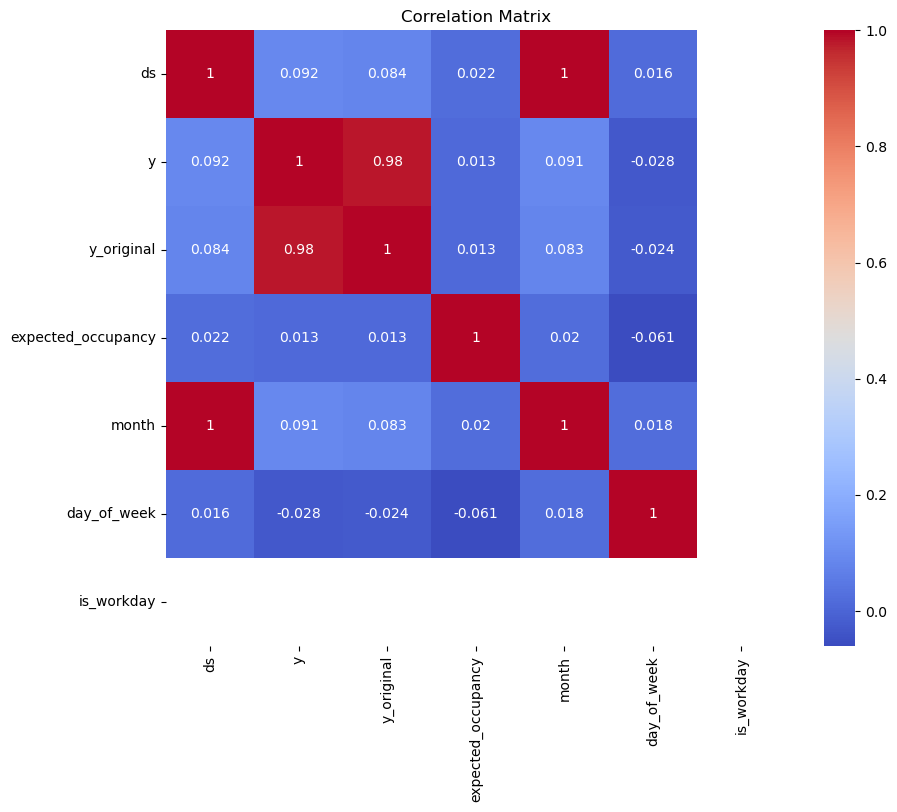

In [38]:
# Correlation Analysis
df_prophet.head()
correlation_matrix = df_prophet.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

#### Insights for Model Development

This correlation analysis is a vital step in preparing our data for occupancy prediction with Prophet. By identifying which variables are most strongly associated with occupancy levels, we can tailor our model to focus on the most influential factors, potentially improving its accuracy and effectiveness.

The heatmap displayed above shows the correlation matrix for the variables within our dataset. It highlights the relationships that will be considered when developing the predictive model to forecast future office occupancy trends.

### Finalizing the Data Cleaning Process

After conducting a thorough analysis and visualization of the data, the final step in our data cleaning notebook involves removing outliers and saving the cleaned dataset. This ensures that our predictive model is trained on high-quality data, which is essential for generating accurate forecasts.

#### Outlier Removal

Outliers can have a disproportionate effect on the model's training process and can lead to overfitting or poor generalization on unseen data. By filtering out these extreme values using our calculated z-scores, we retain only the data points that are within three standard deviations from the mean, which typically encompasses around 99.7% of data in a normal distribution.


In [39]:
# Remove outliers from the dataframe
df_prophet = df_prophet[abs_z_scores <= 3]



#### Saving the Cleaned Dataset

Once the outliers are removed, we save the resulting cleaned dataframe to a CSV file. This file will serve as the input for our occupancy prediction models, providing a solid and reliable foundation for our forecasts.



In [40]:

# Save the merged dataframe
df_prophet.to_csv('./data/df_prophet.csv')


By diligently cleaning and preparing the data, we increase the likelihood of developing a robust and reliable predictive model. The saved dataset is now ready for the next stage in our project, where we will apply Facebook's Prophet to forecast office occupancy levels based on the patterns and relationships we've uncovered in our analysis.

# Conclusion: Ensuring Data Integrity for Predictive Modeling

The data cleaning process we've completed is a testament to the importance of meticulous preparation in predictive analytics. We've imported our raw datasets, conducted preprocessing to create a unified temporal framework, transformed and engineered features for enhanced model compatibility, and visualized the data to understand underlying patterns and detect outliers.

Our thorough analysis included visualizing trends, analyzing the distribution of the target variable, and examining the relationships between different features through correlation analysis. This comprehensive approach not only informed our understanding of the data but also highlighted the importance of each preprocessing step in the context of occupancy prediction.

By removing outliers from the dataset, we've ensured that the data feeding into our predictive model reflects true occupancy patterns, free from the distortion of extreme anomalies. The saved, cleaned dataset is primed for the next phase, where predictive modeling techniques, such as Facebook's Prophet, can be applied to forecast future occupancy trends with greater accuracy.

The cleaned dataset is not just an input for a model; it represents a refined lens through which we can project and plan for future occupancy needs. As we move forward to the modeling stage, we do so with the confidence that comes from a foundation of quality, integrity, and detailed understanding of our data.